# Logistic Regression on Amazon Fine Food Reviews Analysis


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
from prettytable import PrettyTable

#### Reading back the preprocessed data saved in final.sqlite

In [3]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [4]:
df.sort_values('Time', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')

In [5]:
df_data=df[ 0:100000]

In [6]:
X = df_data['CleanedText']
y = df_data['Score']

In [7]:
# split the data set into crossvalidation train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70000,) (70000,) (30000,) (30000,)


### Hyperparameter tuning using GridSearchCV

In [8]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
tuned_parameters = [{'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}]
f1_scorer = make_scorer(f1_score, pos_label="negative")
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = f1_scorer, cv=5)

### Hyperparameter tuning using RandomSearchCV

In [9]:
#soucecode:https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_random_search/

from scipy.stats import uniform
penalty = ['l1', 'l2']
#Create regularization hyperparameter distribution using uniform distribution
C1 = uniform(loc=0, scale=4)
hyperparameters = dict(C=C1, penalty=penalty)
model_random = RandomizedSearchCV(LogisticRegression(),hyperparameters,scoring = f1_scorer, cv=5)

# Bag of Words (BoW)

In [10]:
from sklearn.preprocessing import StandardScaler
count_vec = CountVectorizer()
X_trainbow = count_vec.fit_transform(X_train)
# Test Vectorizor
X_testbow = count_vec.transform(X_test)
X_trainbow_std = StandardScaler(with_mean = False).fit_transform(X_trainbow)

##### Logistic Regression usin GridSearch CV 

In [24]:
model.fit(X_trainbow,y_train)
print(model.best_estimator_)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.01, 1, 100, 10000]}],
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, pos_label=negative), verbose=0)

#### Accuracy Report with Best C

In [11]:

logistic_optimal = LogisticRegression(C=1,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainbow_std, y_train)

# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))

pred_bow = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,70000 , 1000):
    acc_train_bow = logistic_optimal.score(X_trainbow_std[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))


The accuracy of the classifier is 86.820000%
accuracy on train data is 98.9%
error on train data is 1.0999999999999943%
error on test data is 13.180000000000007%


##### Logistic Regression usin RandomSearch CV 

In [37]:
model_random.fit(X_trainbow,y_train)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001405C6D8>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(f1_score, pos_label=negative), verbose=0)

In [14]:

logistic_optimal = LogisticRegression(C=1,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainbow_std, y_train)

# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))

pred_bow = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_bow = accuracy_score(y_test, pred_bow) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,70000 , 1000):
    acc_train_bow = logistic_optimal.score(X_trainbow_std[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_bow))
error_train_bow = (100-acc_train_bow)
print("error on train data is {}%".format(error_train_bow))
error_test_bow = (100-acc_bow)
print("error on test data is {}%".format(error_test_bow))


The accuracy of the classifier is 86.820000%
accuracy on train data is 98.9%
error on train data is 1.0999999999999943%
error on test data is 13.180000000000007%


#### Confusion matrix

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_bow)

array([[ 1405,  3743],
       [  211, 24641]], dtype=int64)

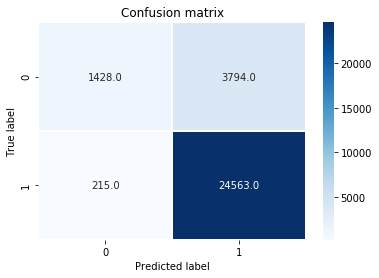

In [51]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_bow)

#### Classification Report

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))

             precision    recall  f1-score   support

   negative       0.87      0.27      0.42      5148
   positive       0.87      0.99      0.93     24852

avg / total       0.87      0.87      0.84     30000



##### Observing Sparsity and error with Variation in  C with L1 Reguralization

In [13]:
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(X_trainbow_std, y_train);
w4 = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w4)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))
pred_bow = np.hstack(predicted_labels)
error_bow_c4=1-accuracy_score(y_test,pred_bow)
print("error with considered c is{}".format(error_bow_c4*100))

number of non zero elements is 0
error with considered c is12.773333333333337


In [14]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_trainbow_std, y_train);
w2 = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w2)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))
pred_bow = np.hstack(predicted_labels)
error_bow_c2=1-accuracy_score(y_test,pred_bow)
print("error with considered c is{}".format(error_bow_c2*100))

number of non zero elements is 3565
error with considered c is12.773333333333337


In [16]:

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_trainbow, y_train);
w1 = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w1)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))
pred_bow = np.hstack(predicted_labels)
error_bow_c1=1-accuracy_score(y_test,pred_bow)
print("error with considered c is{}".format(error_bow_c1*100))

number of non zero elements is 860
error with considered c is12.773333333333337


In [ ]:
clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(X_trainbow, y_train);
w3 = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w3)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testbow[i:i+1000]))
pred_bow = np.hstack(predicted_labels)
error_bow_c3=1-accuracy_score(y_test,pred_bow)
print("error with considered c is{}".format(error_bow_c3*100))

##### Observation:
      As C increases Sparsity Increases,and error remains constant

#### Feature Importance

In [11]:
W = logistic_optimal.coef_
W.shape


(1, 31637)

In [12]:
epsilon=np.random.normal(loc=0.0, scale=0.00000001)
X_trainbow_std.data = X_trainbow_std.data + epsilon

In [13]:
X_trainbow_std.shape

(70000, 31637)

In [14]:
logistic_optimal.fit(X_trainbow_std,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
W1 = logistic_optimal.coef_
W1.size

31637

In [17]:
weights_diff = (abs(W - W1)/W) * 100

In [18]:
print(weights_diff[np.where(weights_diff > 30)].size)

1440


In [19]:
bow_features = count_vec.get_feature_names()

In [20]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = logistic_optimal.coef_
feat_count.shape

(1, 31637)

In [21]:
log_weight = logistic_optimal.coef_[:25]
log_weight


array([[-1.54095643e-05,  6.72225397e-05, -1.93002455e-05, ...,
        -4.13070863e-05,  3.78088409e-03,  7.27680327e-06]])

In [22]:
coefs_feat =pd.DataFrame(sorted(zip(logistic_optimal.coef_[0], bow_features)))
coefs_feat.shape

(31637, 2)

In [23]:
# To show top 25 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",coefs_feat[0:25])
print("\n\n Top 10 Positive Features:-\n",coefs_feat[:-26:-1])

Top 10 Negative Features:-
            0           1
0  -0.901250  disappoint
1  -0.796610       digit
2  -0.768833       worst
3  -0.759677       cattl
4  -0.749269       eugen
5  -0.724947     terribl
6  -0.712163        hair
7  -0.700236      sulfat
8  -0.690993      bloodi
9  -0.635643   autoimmun
10 -0.633890        tast
11 -0.628747        weed
12 -0.612037        moth
13 -0.598190    unfortun
14 -0.587297     rubberi
15 -0.584698          aw
16 -0.583681    techniqu
17 -0.579611         fda
18 -0.572803         fig
19 -0.571092    nauseous
20 -0.561993       threw
21 -0.556178    tobacman
22 -0.555815      refund
23 -0.554213       blech
24 -0.551708      rachel


 Top 10 Positive Features:-
               0            1
31636  2.014222        great
31635  1.762895         love
31634  1.487635         best
31633  1.456395      perfect
31632  1.310296       delici
31631  1.290488         good
31630  1.080806         amaz
31629  1.054797    collector
31628  1.043587       thrive
3

In [24]:
neg_text=coefs_feat[1][0:50].tolist()
pos_text=coefs_feat[1][:-51:-1].tolist()

In [25]:
str1=" ".join(neg_text)
str2=" ".join(pos_text)

#### Wordcloud on Negative Features

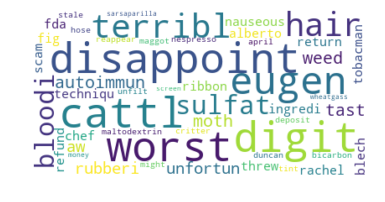

In [26]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Wordcloud on Positive Features

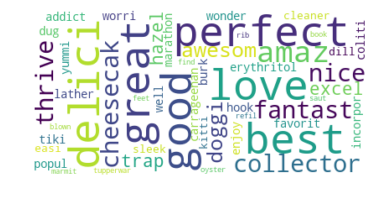

In [27]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(str2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#  TF-IDF

In [16]:
from sklearn import preprocessing

tfidf = TfidfVectorizer() #Using bi-grams
X_traintfidf = tfidf.fit_transform(X_train)
#Normalize Data
X_traintfidf = StandardScaler(with_mean = False).fit_transform(X_traintfidf)
print("Train Data Size: ",X_traintfidf.shape)
X_testtfidf = tfidf.transform(X_test)
#Normalize Data
X_testtfidf = StandardScaler(with_mean = False).fit_transform(X_testtfidf)
print("Test Data Size: ",X_testtfidf.shape)

Train Data Size:  (70000, 31637)
Test Data Size:  (30000, 31637)


##### Logistic Regression usin GridSearch CV 

In [54]:
model.fit(X_traintfidf,y_train)
print(model.best_estimator_)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


##### Accuracy Report with best C

In [17]:

logistic_optimal = LogisticRegression(C=5,penalty='l2')

# fitting the model
logistic_optimal.fit(X_traintfidf, y_train)

# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))

pred_tfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,70000 , 1000):
    acc_train_tfidf = logistic_optimal.score(X_traintfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))


The accuracy of the classifier is 86.820000%
accuracy on train data is 98.7%
error on train data is 1.2999999999999972%
error on test data is 13.786666666666676%


##### Logistic Regression usin RandomSearch CV 

In [57]:
model_random.fit(X_traintfidf,y_train)
print(model.best_estimator_)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


##### Accuracy Report with best C

In [18]:

logistic_optimal = LogisticRegression(C=5,penalty='l2')

# fitting the model
logistic_optimal.fit(X_traintfidf, y_train)

# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))

pred_tfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred_tfidf) * 100
print('\nThe accuracy of the classifier is %f%%' %(acc_bow))
for i in range(0,70000 , 1000):
    acc_train_tfidf = logistic_optimal.score(X_traintfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_tfidf))
error_train_tfidf = (100-acc_train_tfidf)
print("error on train data is {}%".format(error_train_tfidf))
error_test_tfidf = (100-acc_tfidf)
print("error on test data is {}%".format(error_test_tfidf))


The accuracy of the classifier is 86.820000%
accuracy on train data is 98.7%
error on train data is 1.2999999999999972%
error on test data is 13.786666666666676%


#### Confusion Matrix

In [118]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_tfidf)

array([[ 3155,  1993],
       [ 2143, 22709]], dtype=int64)

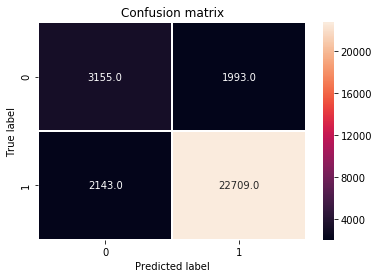

In [76]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_tfidf)

#### Classification Report 

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_tfidf))

             precision    recall  f1-score   support

   negative       0.60      0.61      0.60      5148
   positive       0.92      0.91      0.92     24852

avg / total       0.86      0.86      0.86     30000



##### Observing Sparsity and error with Variation in  C with L1 Reguralization

In [60]:
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(X_traintfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))
pred_tfidf = np.hstack(predicted_labels)
error_tfidf=1-accuracy_score(y_test,pred_tfidf)
print("error with considered c is{}".format(error_tfidf*100))

number of non zero elements is 0
error with considered c is8.830000000000005


In [61]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_traintfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))
pred_tfidf = np.hstack(predicted_labels)
error_tfidf=1-accuracy_score(y_test,pred_tfidf)
print("error with considered c is{}".format(error_tfidf*100))

number of non zero elements is 6
error with considered c is8.830000000000005


In [62]:
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_traintfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))
pred_tfidf = np.hstack(predicted_labels)
error_tfidf=1-accuracy_score(y_test,pred_tfidf)
print("error with considered c is{}".format(error_tfidf*100))

number of non zero elements is 7738
error with considered c is8.830000000000005


In [63]:
clf = LogisticRegression(C=100, penalty='l1');
clf.fit(X_traintfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))
pred_tfidf = np.hstack(predicted_labels)
error_tfidf=1-accuracy_score(y_test,pred_tfidf)
print("error with considered c is{}".format(error_tfidf*100))

number of non zero elements is 12812
error with considered c is8.830000000000005


In [64]:
clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(X_traintfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testtfidf[i:i+1000]))
pred_tfidf = np.hstack(predicted_labels)
error_tfidf=1-accuracy_score(y_test,pred_tfidf)
print("error with considered c is{}".format(error_tfidf*100))

number of non zero elements is 15174
error with considered c is8.830000000000005


##### Observation:
      As C increases Sparsity Increases,and error remains constant

#### Feature Importance

In [103]:
W = logistic_optimal.coef_
W

array([[ 0.00252494, -0.0129206 , -0.00673267, ..., -0.00277525,
         0.00660597,  0.00010064]])

In [104]:
epsilon=np.random.normal(loc=0.0, scale=0.00000001)
X_traintfidf.data = X_traintfidf.data + epsilon

In [105]:
tfidf_features = tfidf.get_feature_names()
len(tfidf_features)

31637

In [106]:
logistic_optimal.fit(X_traintfidf,y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
W1 = logistic_optimal.coef_
W1

array([[ 0.00190069, -0.01283882, -0.00947135, ..., -0.00396797,
         0.00659186,  0.00015672]])

In [108]:
weights_diff = (abs(W - W1)/W) * 100

In [109]:
print(weights_diff[np.where(weights_diff > 30)].size)

1387


In [110]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = logistic_optimal.coef_
feat_count.shape

(1, 31637)

In [111]:
log_weight = logistic_optimal.coef_[:25]
log_weight

array([[ 0.00190069, -0.01283882, -0.00947135, ..., -0.00396797,
         0.00659186,  0.00015672]])

In [112]:
coefs_feat =pd.DataFrame(sorted(zip(logistic_optimal.coef_[0], tfidf_features)))
#feature = pd.DataFrame(log_prob, columns = bow_features)
coefs_feat.shape

(31637, 2)

In [113]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",coefs_feat[0:25])
print("\n\n Top 10 Positive Features:-\n",coefs_feat[:-26:-1])

Top 10 Negative Features:-
            0             1
0  -0.928103        ridder
1  -0.691079         blech
2  -0.656800    disappoint
3  -0.638443         worst
4  -0.610003        higgin
5  -0.558963         fauls
6  -0.556661      nastiest
7  -0.537723        rachel
8  -0.523228       terribl
9  -0.512943       fluorid
10 -0.508157        maggot
11 -0.503768       deposit
12 -0.502716       offload
13 -0.484960   meaningless
14 -0.483106           rot
15 -0.483058       spaniel
16 -0.480154          tast
17 -0.477541     ascertain
18 -0.476700      prolifer
19 -0.472125      nauseous
20 -0.462346  sarsaparilla
21 -0.460129        bloodi
22 -0.457078      unaccept
23 -0.454196         threw
24 -0.421972          scam


 Top 10 Positive Features:-
               0          1
31636  1.884218  collector
31635  1.847649      great
31634  1.587038       love
31633  1.490453     caviti
31632  1.340035      hazel
31631  1.275846       best
31630  1.227458    perfect
31629  1.215736     del

In [114]:
neg_text=coefs_feat[1][0:50].tolist()
pos_text=coefs_feat[1][:-51:-1].tolist()

In [115]:
str1=" ".join(neg_text)
str2=" ".join(pos_text)

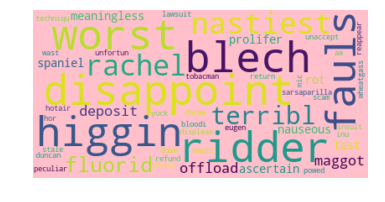

In [116]:
#Sourcecode:https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="pink").generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

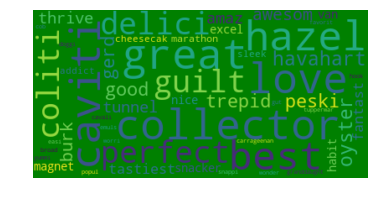

In [117]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="green").generate(str2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word TO Vec

In [12]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
# Train your own Word2Vec model using your own train corpus
import gensim
list_of_sent = []
for sent in X_train:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
print(df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['hate', 'junk', 'food', 'need', 'snack', 'stori', 'life', 'wonder', 'tast', 'good', 'enough', 'children', 'like', 'healthi', 'keep', 'box', 'car', 'case', 'run', 'hous', 'without', 'breakfast', 'daughter', 'need', 'quick', 'snack', 'right', 'school']


In [15]:
# min_count = 5 considers only words that occured atleast 5 times

from gensim.models import Word2Vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [16]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10722
sample words  ['hate', 'junk', 'food', 'need', 'snack', 'stori', 'life', 'wonder', 'tast', 'good', 'enough', 'children', 'like', 'healthi', 'keep', 'box', 'car', 'case', 'run', 'hous', 'without', 'breakfast', 'daughter', 'quick', 'right', 'school', 'live', 'california', 'drawback', 'one', 'lack', 'flake', 'bar', 'know', 'sound', 'silli', 'assur', 'serious', 'issu', 'amazon', 'rescu', 'alway', 'look', 'someth', 'that', 'sometim', 'youd', 'get', 'flavor', 'eat']


In [17]:
# Train your own Word2Vec model using your own test corpus
import gensim
list_of_sent_test = []
for sent in X_test:
    filtered_sentence1 = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence1.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence1)

In [18]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# Avg W2V, TFIDF-W2V

In [52]:
from tqdm import tqdm
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████████████████████████████| 70000/70000 [00:26<00:00, 2619.99it/s]


70000
50


In [53]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████████████████████████████| 30000/30000 [00:11<00:00, 2538.45it/s]


30000
50


In [60]:
X_trainw2v = np.array(sent_vectors)
X_testw2v=np.array(sent_vectors_test)
X_trainw2v=np.nan_to_num(X_trainw2v)
X_testw2v=np.nan_to_num(X_testw2v)

In [61]:
X_trainw2v.shape

(70000, 50)

In [62]:
X_trainw2v = StandardScaler(with_mean = False).fit_transform(X_trainw2v)
X_testw2v = StandardScaler(with_mean = False).fit_transform(X_testw2v)

##### Logistic Regression usin GridSearch CV 

In [96]:
model.fit(X_trainw2v,y_train)
print(model.best_estimator_)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#####  AccuracyScore with Best C

In [63]:

logistic_optimal = LogisticRegression(C=50,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2v, y_train)
X_testw2v=np.nan_to_num(X_testw2v)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))

pred_w2v = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the knn classifier for k is %f%%' %(acc_w2v))
for i in range(0,70000 , 1000):
    acc_train_w2v = logistic_optimal.score(X_trainw2v[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the knn classifier for k is 87.890000%
accuracy on train data is 88.7%
error on train data is 11.299999999999997%
error on test data is 12.11%


##### Logistic Regression usin RandomSearch CV 

In [44]:
model_random.fit(X_trainw2v,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000436FDEF0>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(f1_score, pos_label=negative), verbose=0)

#####  AccuracyScore with Best C

In [46]:

logistic_optimal = LogisticRegression(C=1,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2v, y_train)
X_testw2v=np.nan_to_num(X_testw2v)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))

pred_w2v = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2v = accuracy_score(y_test, pred_w2v) * 100
print('\nThe accuracy of the knn classifier for k is %f%%' %(acc_w2v))
for i in range(0,70000 , 1000):
    acc_train_w2v = logistic_optimal.score(X_trainw2v[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the knn classifier for k is 87.980000%
accuracy on train data is 89.1%
error on train data is 10.900000000000006%
error on test data is 12.019999999999996%


#### Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2v)

array([[ 2569,  2579],
       [ 1027, 23825]], dtype=int64)

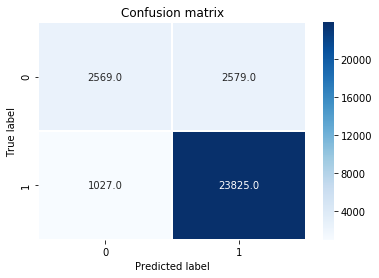

In [48]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix', cmap="Blues"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5,cmap=cmap)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2v)

#### Classification Report 

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2v))

             precision    recall  f1-score   support

   negative       0.71      0.50      0.59      5148
   positive       0.90      0.96      0.93     24852

avg / total       0.87      0.88      0.87     30000



##### Observing Sparsity and error with Variation in  C with L1 Reguralization

In [53]:
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(X_trainw2v, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))
pred_w2v = np.hstack(predicted_labels)
error_w2v=1-accuracy_score(y_test,pred_w2v)
print("error with considered c is{}".format(error_w2v*100))

number of non zero elements is 4
error with considered c is12.026666666666664


In [54]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_trainw2v, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))
pred_w2v = np.hstack(predicted_labels)
error_w2v=1-accuracy_score(y_test,pred_w2v)
print("error with considered c is{}".format(error_w2v*100))

number of non zero elements is 46
error with considered c is12.026666666666664


In [55]:
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_trainw2v, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))
pred_w2v = np.hstack(predicted_labels)
error_w2v=1-accuracy_score(y_test,pred_w2v)
print("error with considered c is{}".format(error_w2v*100))

number of non zero elements is 50
error with considered c is12.026666666666664


In [56]:
clf = LogisticRegression(C=100, penalty='l1');
clf.fit(X_trainw2v, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))
pred_w2v = np.hstack(predicted_labels)
error_w2v=1-accuracy_score(y_test,pred_w2v)
print("error with considered c is{}".format(error_w2v*100))

number of non zero elements is 50
error with considered c is12.026666666666664


In [57]:
clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(X_trainw2v, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2v[i:i+1000]))
pred_w2v = np.hstack(predicted_labels)
error_w2v=1-accuracy_score(y_test,pred_w2v)
print("error with considered c is{}".format(error_w2v*100))

number of non zero elements is 50
error with considered c is12.026666666666664


##### Observation:
      As C increases Sparsity Increases,and error remains constant

#### Feature Importance

In [72]:
W = logistic_optimal.coef_
W

array([[-0.06771146, -0.09941234,  0.35773035,  0.20579285,  0.14481853,
         0.54441686,  0.59574529, -0.33653803,  0.22673692, -0.08772986,
        -0.11855361, -0.10099276, -0.06602735, -0.17922599, -0.069445  ,
         0.19732253, -0.22180996, -0.24296693,  0.53620418,  0.40204373,
        -0.24564318,  0.00615912, -0.64919357, -1.08565011, -0.60377191,
        -0.12467971,  0.22971051, -0.10664254,  0.62521595, -0.02056749,
        -0.08295365,  0.13082139, -0.25751081, -0.15310661,  0.03051704,
         0.10269255, -0.54321582,  0.10877575, -0.21298834,  0.23011012,
         0.86333828,  0.22920714,  0.48162131,  0.05921252,  0.04135274,
        -0.09154579, -0.18533407, -0.00627418,  0.24117636, -0.04522534]])

In [73]:

X_trainw2v_t = X_trainw2v
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(X_trainw2v_t[0].size)) 
#Introducing random noise to non-zero datapoints
X_trainw2v_t.data = epsilon + X_trainw2v_t.data

In [74]:
logistic_optimal.fit(X_trainw2v_t,y_train)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
W1 = logistic_optimal.coef_
W1

array([[-0.06787585, -0.09961273,  0.35720064,  0.20578602,  0.1454733 ,
         0.54451759,  0.59508615, -0.33711765,  0.22709587, -0.08785405,
        -0.11722975, -0.10081888, -0.06625175, -0.17927366, -0.06940623,
         0.19754684, -0.22231138, -0.24306177,  0.53699848,  0.40155781,
        -0.24602828,  0.00607195, -0.64841184, -1.08586481, -0.60427415,
        -0.12414289,  0.22985111, -0.10664662,  0.62463802, -0.02118795,
        -0.0823991 ,  0.13109697, -0.25691811, -0.15334841,  0.03124232,
         0.10264753, -0.54301734,  0.10808121, -0.21236513,  0.23053376,
         0.86248518,  0.2289062 ,  0.48185442,  0.05973942,  0.04080134,
        -0.09170732, -0.18529765, -0.00648717,  0.24149927, -0.045066  ]])

In [76]:
weights_diff = (abs(W - W1)/W) * 100

In [77]:
print(weights_diff[np.where(weights_diff > 30)].size)

0


Hence the feature are not multicolinear

## TF-IDF weighted Word2Vec

In [19]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [22]:
from tqdm import tqdm
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 70000/70000 [03:14<00:00, 359.27it/s]


In [23]:
# TF-IDF weighted Word2Vec
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            if word in w2v_words:
                vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 30000/30000 [01:29<00:00, 336.76it/s]


In [24]:

X_trainw2vtfidf=np.array(tfidf_sent_vectors)
X_testw2vtfidf=np.array(tfidf_sent_vectors_test)

In [25]:
X_trainw2vtfidf.shape


(70000, 50)

In [29]:
X_trainw2vtfidf = StandardScaler(with_mean = False).fit_transform(X_trainw2vtfidf)
X_testw2vtfidf = StandardScaler(with_mean = False).fit_transform(X_testw2vtfidf)

In [133]:
X_trainw2vtfidf=np.nan_to_num(X_trainw2vtfidf)

##### Logistic Regression usin GridSearch CV 

In [96]:
model.fit(X_trainw2vtfidf,y_train)
print(model.best_estimator_)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


#####  AccuracyScore with best C

In [72]:

logistic_optimal = LogisticRegression(C=50,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2vtfidf, y_train)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))

pred_w2vtfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2v = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the  classifier for k is %f%%' %(acc_w2v))
for i in range(0,70000 , 1000):
    acc_train_w2v = logistic_optimal.score(X_trainw2vtfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2v))
error_train_w2v = (100-acc_train_w2v)
print("error on train data is {}%".format(error_train_w2v))
error_test_w2v = (100-acc_w2v)
print("error on test data is {}%".format(error_test_w2v))


The accuracy of the  classifier for k is 87.216667%
accuracy on train data is 87.5%
error on train data is 12.5%
error on test data is 12.783333333333331%


#### Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2vtfidf)

array([[ 1358,  3032],
       [  804, 24806]], dtype=int64)

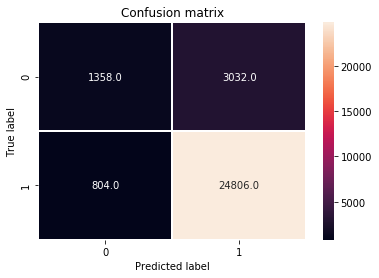

In [37]:
import seaborn as sns
def plot_confusion_matrix(targets, predictions,title='Confusion matrix'):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(targets, predictions)
   # cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    df = pd.DataFrame(data=cm)
    g = sns.heatmap(df, annot=True, fmt=".1f", linewidths=.5)
    g.set_title(title)
    g.set_ylabel('True label')
    g.set_xlabel('Predicted label')
    return g
plot_confusion_matrix(y_test, pred_w2vtfidf)

#### Classification Report

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2vtfidf))

             precision    recall  f1-score   support

   negative       0.63      0.31      0.41      4390
   positive       0.89      0.97      0.93     25610

avg / total       0.85      0.87      0.85     30000



##### Logistic Regression usin RandomSearchCV 

In [110]:
model_random.fit(X_trainw2vtfidf,y_train)
print(model_random.best_estimator_)

LogisticRegression(C=3.335990152517682, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


#####  AccuracyScore with best C

In [35]:

logistic_optimal = LogisticRegression(C=3.336,penalty='l2')

# fitting the model
logistic_optimal.fit(X_trainw2vtfidf, y_train)
X_testw2vtfidf=np.nan_to_num(X_testw2vtfidf)
# predict the response

predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))

pred_w2vtfidf = np.hstack(predicted_labels)
#pred_bow= knn_optimal.predict(X_testbow)
# evaluate accuracy
acc_w2vtfidf = accuracy_score(y_test, pred_w2vtfidf) * 100
print('\nThe accuracy of the  classifier for k is %f%%' %(acc_w2vtfidf))
for i in range(0,70000 , 1000):
    acc_train_w2vtfidf = logistic_optimal.score(X_trainw2vtfidf[i:i+1000],y_train[i:i+1000])*100
print("accuracy on train data is {}%".format(acc_train_w2vtfidf))
error_train_w2vtfidf = (100-acc_train_w2vtfidf)
print("error on train data is {}%".format(error_train_w2vtfidf))
error_test_w2vtfidf = (100-acc_w2vtfidf)
print("error on test data is {}%".format(error_test_w2vtfidf))


The accuracy of the  classifier for k is 87.213333%
accuracy on train data is 87.6%
error on train data is 12.400000000000006%
error on test data is 12.786666666666662%


#### Confusion Matrix

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_w2vtfidf)

array([[ 1352,  3038],
       [  797, 24813]], dtype=int64)

#### Classification Report

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_w2vtfidf))

             precision    recall  f1-score   support

   negative       0.63      0.31      0.41      4390
   positive       0.89      0.97      0.93     25610

avg / total       0.85      0.87      0.85     30000



##### Observing Sparsity and error with Variation in  C with L1 Reguralization

In [75]:
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(X_trainw2vtfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))
pred_w2vtfidf = np.hstack(predicted_labels)
error_w2vtfidf=1-accuracy_score(y_test,pred_w2vtfidf)
print("error with considered c is{}".format(error_w2vtfidf*100))

number of non zero elements is 21
error with considered c is12.783333333333335


In [40]:
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_trainw2vtfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))
pred_w2vtfidf = np.hstack(predicted_labels)
error_w2vtfidf=1-accuracy_score(y_test,pred_w2vtfidf)
print("error with considered c is{}".format(error_w2vtfidf*100))

number of non zero elements is 41
error with considered c is12.786666666666669


In [41]:
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(X_trainw2vtfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))
pred_w2vtfidf = np.hstack(predicted_labels)
error_w2vtfidf=1-accuracy_score(y_test,pred_w2vtfidf)
print("error with considered c is{}".format(error_w2vtfidf*100))

number of non zero elements is 50
error with considered c is12.786666666666669


In [42]:
clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(X_trainw2vtfidf, y_train);
w = clf.coef_
print("number of non zero elements is {}".format(np.count_nonzero(w)))
predicted_labels = []
for i in range(0,30000 , 1000):
    predicted_labels.append(logistic_optimal.predict(X_testw2vtfidf[i:i+1000]))
pred_w2vtfidf = np.hstack(predicted_labels)
error_w2vtfidf=1-accuracy_score(y_test,pred_w2vtfidf)
print("error with considered c is{}".format(error_w2vtfidf*100))

number of non zero elements is 50
error with considered c is12.786666666666669


##### Observation:
      As C increases Sparsity Increases,and error remains constant

#### Feature Importance

In [76]:
W = logistic_optimal.coef_
W

array([[-0.25558396,  0.57494661,  0.00711789, -0.65785604, -0.27931792,
        -0.4097427 ,  0.32329917, -0.1859115 , -0.65883312,  0.02444393,
        -0.0502134 , -0.29511938,  0.0875272 , -0.50513724, -0.60109172,
         0.18786946,  0.25684579,  0.30908055, -0.21204647,  0.50998597,
        -0.50136819, -0.4357827 ,  0.0115215 ,  0.25135067, -0.17490819,
         0.19357911,  0.01582643, -0.10204661,  1.11068417,  0.14857146,
        -0.18229406, -0.20346703, -0.09361862, -0.3891112 , -1.00196329,
         0.65532744,  0.00122048, -0.06075404,  0.29491883,  0.09957108,
         0.19458459,  0.67269351,  0.16777464,  0.55995976,  0.56584894,
        -0.5982602 , -0.52510415,  0.08397951,  0.14569792, -0.39194503]])

In [77]:
X_trainw2vtfidf_n=X_trainw2vtfidf
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(X_trainw2vtfidf_n[0].size)) 
X_trainw2vtfidf_n.data = X_trainw2vtfidf_n.data + epsilon

In [78]:
logistic_optimal.fit(X_trainw2vtfidf_n,y_train)

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
W1 = logistic_optimal.coef_
W1

array([[-0.25571705,  0.57485853,  0.00698782, -0.65774865, -0.27954607,
        -0.40966756,  0.3233472 , -0.18591435, -0.65871299,  0.02479745,
        -0.05014565, -0.29513754,  0.08740053, -0.50516648, -0.60106341,
         0.18747232,  0.25662303,  0.30923353, -0.21206165,  0.5098912 ,
        -0.50109985, -0.43547861,  0.01149002,  0.2513981 , -0.17485171,
         0.19361119,  0.01586069, -0.10209383,  1.11045339,  0.14858093,
        -0.18228764, -0.20338854, -0.09378907, -0.38924594, -1.00212112,
         0.65538366,  0.00118149, -0.06088345,  0.29509745,  0.09962729,
         0.19431118,  0.67252163,  0.1679162 ,  0.56024699,  0.5657848 ,
        -0.59833909, -0.52493114,  0.08413078,  0.14568158, -0.39192756]])

In [80]:
weights_diff = (abs(W - W1)/W) * 100

In [84]:
print(weights_diff[np.where(weights_diff > 30)].size)

0


Hence the features are not Multicolinear

## Conclusion
1)AVG W2V Featurization performs best with accuracy of 93.704 and F1-Score of 0.808
2)Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used
3)Logistic Regression performed best on this data

## Performance Table

In [6]:
x = PrettyTable()

x.field_names = ["Featurization", "CV","C", "Penalty","Accuracy","F1 Score"]

x.add_row(["BOW","GridSearch", 1,"L2" ,86.82,0.87])
x.add_row(["BOW","RandomSearch",1,"L2",86.82,0.87])
x.add_row(["TFIDF","GridSearch", 5,"L2" ,86.82,0.86])
x.add_row(["TFIDF","RandomSearch",5,"L2",86.82,0.86])
x.add_row(["AVG W2V","GridSearch", 50,"L2" ,87.98,0.87])
x.add_row(["AVG W2V","RandomSearch",1,"L2",87.89,0.86])
x.add_row(["TFIDF W2V","GridSearch", 50,"L2" ,87.21,0.85])
x.add_row(["TFIDF W2V","RandomSearch",3.336,"L2",87.21,0.85])

print(x)


+---------------+--------------+-------+---------+----------+----------+
| Featurization |      CV      |   C   | Penalty | Accuracy | F1 Score |
+---------------+--------------+-------+---------+----------+----------+
|      BOW      |  GridSearch  |   1   |    L2   |  86.82   |   0.87   |
|      BOW      | RandomSearch |   1   |    L2   |  86.82   |   0.87   |
|     TFIDF     |  GridSearch  |   5   |    L2   |  86.82   |   0.86   |
|     TFIDF     | RandomSearch |   5   |    L2   |  86.82   |   0.86   |
|    AVG W2V    |  GridSearch  |   50  |    L2   |  87.98   |   0.87   |
|    AVG W2V    | RandomSearch |   1   |    L2   |  87.89   |   0.86   |
|   TFIDF W2V   |  GridSearch  |   50  |    L2   |  87.21   |   0.85   |
|   TFIDF W2V   | RandomSearch | 3.336 |    L2   |  87.21   |   0.85   |
+---------------+--------------+-------+---------+----------+----------+
